In [1]:
import networkx as nx
import pandas as pd
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from rdflib.namespace import RDF, SOSA

from viscars.data import DataLoader
from viscars.evaluation.evaluators.kfoldcv import KFoldCrossValidation
from viscars.evaluation.evaluators.loocv import LeaveOneOutCrossValidation
from viscars.evaluation.metrics import MetricType
from viscars.evaluation.metrics.factory import MetricFactory
from viscars.namespace import DASHB
from viscars.recommenders.factory import RecommenderFactory, RecommenderType
from viscars.utils import visualize_graph

In [2]:
project = 'proeftuin'

graph = Graph()
graph.parse(f'./data/{project}/graph.ttl', format='n3')

metric_factory = MetricFactory()
recommender_factory = RecommenderFactory()

metrics = ['f1@1', 'ndcg@1', 'ndcg@3']
parsed_metrics = []
for metric in metrics:
    m_split = metric.split('@')
    m_type = m_split[0]
    n = int(m_split[1]) if len(m_split) >= 2 else None

    metric_ = metric_factory.get(MetricType.reverse_lookup(m_type), n)
    parsed_metrics.append(metric_)

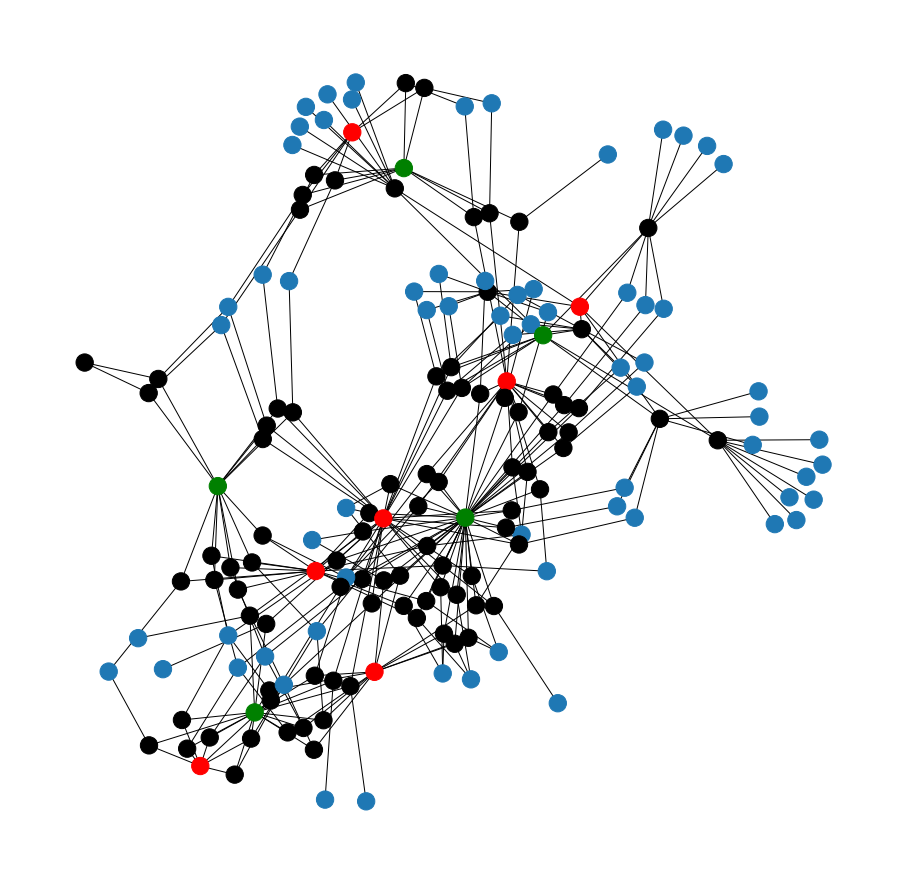

In [3]:
def create_subgraph(relations):
    subgraph = Graph()
    for r in relations:
        subgraph += graph.triples((None, r, None))

    nodes = set()
    nodes.update(subgraph.subjects())
    nodes.update(subgraph.objects())

    for node in nodes:
        subgraph += graph.triples((node, RDF.type, None))
    return subgraph

uid = ['https://dynamicdashboard.ilabt.imec.be/users/11']
cid = ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber']

included_relationships = [DASHB.createdBy, DASHB.visualizedBy, DASHB.hasProperty]
graph_ = create_subgraph(included_relationships)
visualize_graph(graph_, colored=True)

In [4]:
users = list(graph_.subjects(RDF.type, DASHB.User))
print(users)

[rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/11'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/12'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/10'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/9'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/8'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/7'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/6')]


In [5]:
cfs = set(graph_.subjects(RDF.type, SOSA.ObservableProperty))
print(cfs)

{rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.BDF%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB5/properties/acc.kurtosis%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB3/properties/acc.kurtosis%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB6/properties/acc.BPFI%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/acc.BPFI%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.peak%3A%3Anumber'), rdflib.term.URIRef('https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/pdm.RUL%3A%3Anumber')

In [6]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)

ppr = recommender.run()

In [7]:
recommendations = recommender.predict()

for r in recommendations:
    print(r)

{'contextId': None, 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.03601556216940091}
{'contextId': None, 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'), 'score': 0.017807227303416998}
{'contextId': None, 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), 'score': 0.014061971667749262}
{'contextId': None, 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), 'score': 0.011487856766170115}
{'contextId': None, 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.01088568884946614}


In [8]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run(uid, [])

In [9]:
recommendations = recommender.predict(uid, [])

for r in recommendations:
    print(r)

{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.038968837557425445}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), 'score': 0.027267256319023644}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'), 'score': 0.008262343298897246}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.004353930274503364}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), 'score': 0.0033844887519012806}


In [10]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run([], cid)

In [11]:
recommendations = recommender.predict([], cid)

for r in recommendations:
    print(r)

{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.02582411635141605}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.016859647470499502}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'), 'score': 0.0059409303275909705}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/

In [12]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run(uid, cid)

In [13]:
recommendations = recommender.predict(uid, cid)

for r in recommendations:
    print(r)

{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.03233608053134753}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), 'score': 0.020750150277710808}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.010794986097577255}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-

### Introducing UserGroup

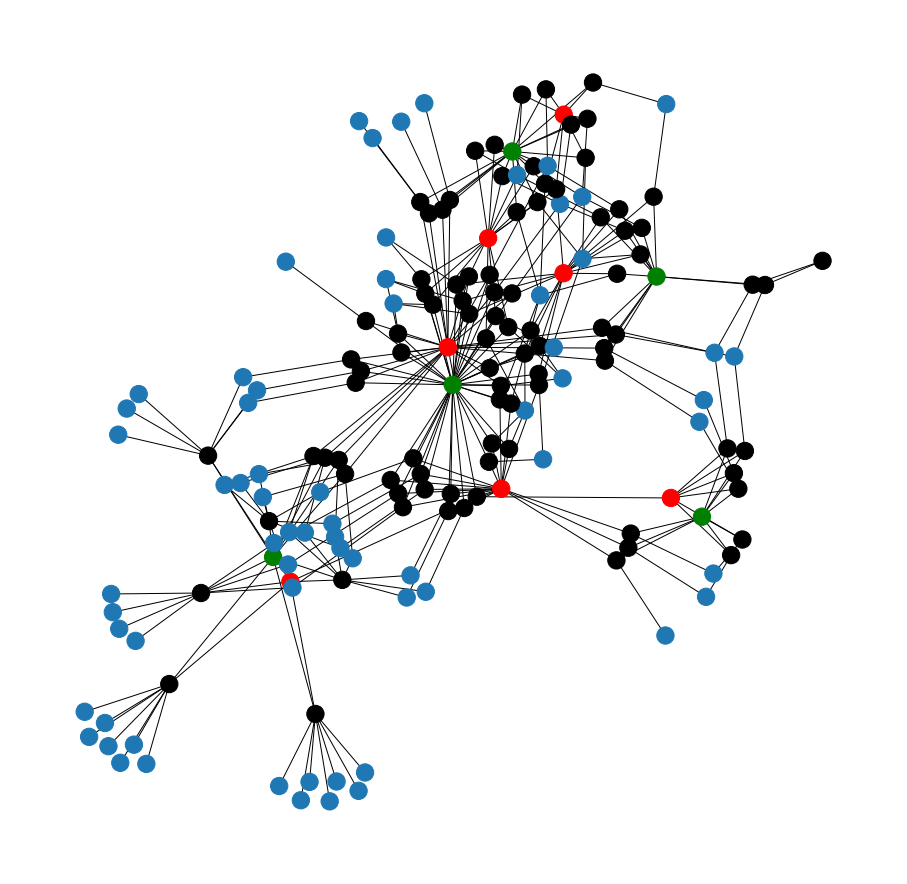

In [14]:
included_relationships.append(DASHB.memberOf)
graph_ = create_subgraph(included_relationships)
visualize_graph(graph_, colored=True)

In [15]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
ppr = recommender.run()

for u in users:
    print(f'[{ppr[u]}] {u}) - #Widgets = {len(list(graph_.triples((None, DASHB.createdBy, u))))}')
    
usergroup = list(graph_.objects(URIRef(uid[0]), DASHB.memberOf))[0]
print(f'[{ppr[usergroup]}] {usergroup}')

[0.014097902380026776] https://dynamicdashboard.ilabt.imec.be/users/11) - #Widgets = 14
[0.008487287960619278] https://dynamicdashboard.ilabt.imec.be/users/12) - #Widgets = 7
[0.012448405707130454] https://dynamicdashboard.ilabt.imec.be/users/10) - #Widgets = 12
[0.017431029387456533] https://dynamicdashboard.ilabt.imec.be/users/9) - #Widgets = 18
[0.007754605758582135] https://dynamicdashboard.ilabt.imec.be/users/8) - #Widgets = 6
[0.007817348725505662] https://dynamicdashboard.ilabt.imec.be/users/7) - #Widgets = 6
[0.02246867518512625] https://dynamicdashboard.ilabt.imec.be/users/6) - #Widgets = 24
[0.00441593520258172] https://dynamicdashboard.ilabt.imec.be/groups/maintenance


In [16]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run(uid, [])

In [17]:
for u in users:
    print(f'[{ppr[u]}] {u}) - #Widgets = {len(list(graph_.triples((None, DASHB.createdBy, u))))}')
    
usergroup = list(graph_.objects(URIRef(uid[0]), DASHB.memberOf))[0]
print(f'[{ppr[usergroup]}] {usergroup}')

[0.2464074699554036] https://dynamicdashboard.ilabt.imec.be/users/11) - #Widgets = 14
[0.008368617141187652] https://dynamicdashboard.ilabt.imec.be/users/12) - #Widgets = 7
[0.01113216046740872] https://dynamicdashboard.ilabt.imec.be/users/10) - #Widgets = 12
[0.00987484943576425] https://dynamicdashboard.ilabt.imec.be/users/9) - #Widgets = 18
[0.0035420716613063087] https://dynamicdashboard.ilabt.imec.be/users/8) - #Widgets = 6
[0.004259702714042029] https://dynamicdashboard.ilabt.imec.be/users/7) - #Widgets = 6
[0.012573262784679514] https://dynamicdashboard.ilabt.imec.be/users/6) - #Widgets = 24
[0.015092272376734564] https://dynamicdashboard.ilabt.imec.be/groups/maintenance


In [18]:
recommendations = recommender.predict(uid, [])

for r in recommendations:
    print(r)

{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.037144877566105}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), 'score': 0.02571300463849931}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'), 'score': 0.008610781915670836}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.004152485537541756}
{'contextId': [], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/multiple-time-series-line-chart-with-time-range-selector'), 'score': 0.003247867301942508}


In [19]:
usergroups = list(graph_.subjects(RDF.type, DASHB.UserGroup))
print(usergroups)

[rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/groups/maintenance'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/groups/operator')]


In [20]:
uidgroup = list(graph_.objects(URIRef(uid[0]), DASHB.memberOf))[0]
print(uidgroup)

https://dynamicdashboard.ilabt.imec.be/groups/maintenance


In [21]:
groupmembers = list(graph_.subjects(DASHB.memberOf, uidgroup))
print(groupmembers)

[rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/12'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/10'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/users/11')]


In [22]:
userwidgets = list(graph_.subjects(DASHB.createdBy, URIRef(uid[0])))
print(userwidgets)

[rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/47'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/48'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/49'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/50'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/51'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/52'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/53'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/54'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/55'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/56'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/57'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/58'), rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/59'), rdflib.term.URIRef('https://dynamicdashboard.ilabt

In [23]:
uservisualizations = {}
for w in userwidgets:
    for v in list(graph_.objects(w, DASHB.visualizedBy)):
        if v not in uservisualizations.keys():
            uservisualizations[v] = 1
        else:
            uservisualizations[v] += 1
print(uservisualizations)

{rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'): 7, rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'): 7}


### Introducing Metrics

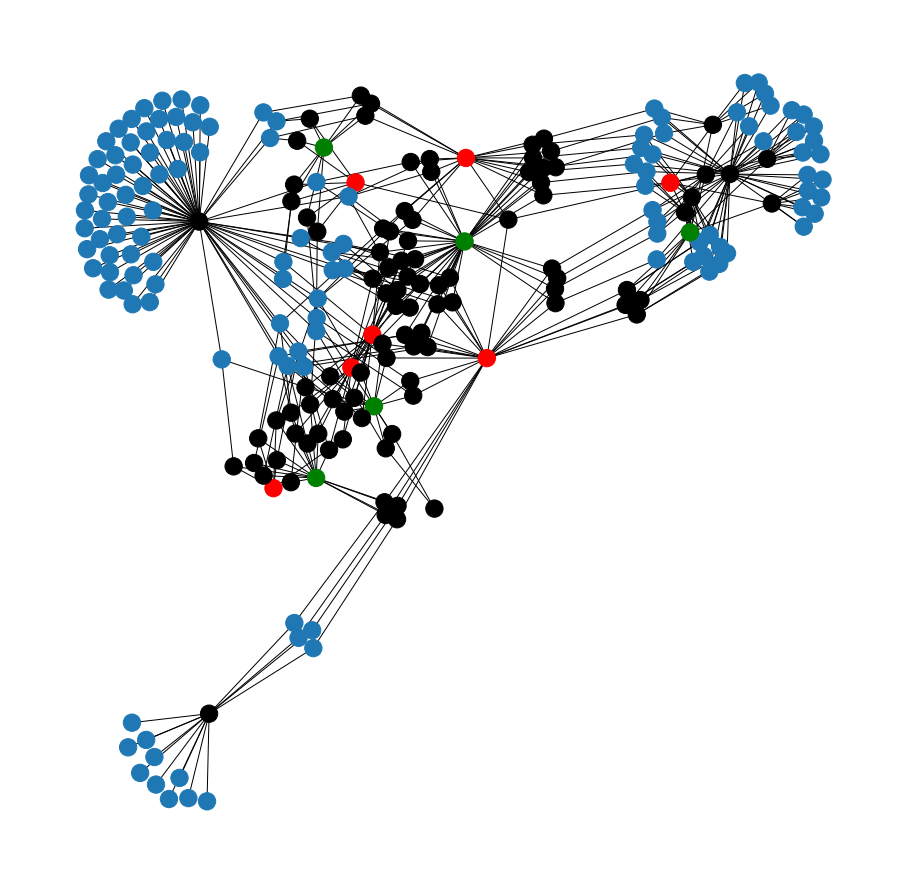

In [24]:
included_relationships.append(DASHB.produces)
graph_ = create_subgraph(included_relationships)
visualize_graph(graph_, colored=True)

In [25]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
ppr = recommender.run()

for cf in cfs:
    print(f'[{ppr[cf]}] {cf}) - #Widgets = {len(list(graph_.subjects(DASHB.hasProperty, cf)))}')
    
metric = list(graph_.objects(URIRef(cid[0]), DASHB.produces))[0]
print(f'[{ppr[metric]}] {metric})')

[0.003025724934139972] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.BDF%3A%3Anumber) - #Widgets = 2
[0.003026283513396802] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB5/properties/acc.kurtosis%3A%3Anumber) - #Widgets = 2
[0.0031812824952090306] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber) - #Widgets = 2
[0.002458219173287334] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB3/properties/acc.kurtosis%3A%3Anumber) - #Widgets = 1
[0.002990813308850126] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB6/properties/acc.BPFI%3A%3Anumber) - #Widgets = 2
[0.002990813308850126] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/acc.BPFI%3A%3Anumber) - #Widgets = 2
[0.0024705178154007107] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.peak%3A%3Anumber) - #Widgets = 1
[0.003698

In [26]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run([], cid)

for cf in cfs:
    print(f'[{ppr[cf]}] {cf}) - #Widgets = {len(list(graph_.subjects(DASHB.hasProperty, cf)))}')
    
metric = list(graph_.objects(URIRef(cid[0]), DASHB.produces))[0]
print(f'[{ppr[metric]}] {metric})')

[0.001601542421592455] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.BDF%3A%3Anumber) - #Widgets = 2
[0.0014728580430591967] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB5/properties/acc.kurtosis%3A%3Anumber) - #Widgets = 2
[0.002689696766189885] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/rpm%3A%3Anumber) - #Widgets = 2
[0.0012767280128403494] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB3/properties/acc.kurtosis%3A%3Anumber) - #Widgets = 1
[0.0014712628400662248] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB6/properties/acc.BPFI%3A%3Anumber) - #Widgets = 2
[0.0014712628400662248] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB4/properties/acc.BPFI%3A%3Anumber) - #Widgets = 2
[0.0012945866452484674] https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB2/properties/acc.peak%3A%3Anumber) - #Widgets = 1
[0.002

In [27]:
recommendations = recommender.predict([], cid)

for r in recommendations:
    print(r)

{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.016771664803103298}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.010711318795999288}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-measurement'), 'score': 0.0039000641937323335}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations

In [28]:
propretywidgets = list(graph_.subjects(DASHB.hasProperty, URIRef(cid[0])))
print(propretywidgets)

[rdflib.term.URIRef('https://dynamicdashboard.ilabt.imec.be/widgets/71')]


In [29]:
propertyvisualizations = {}
for w in propretywidgets:
    for v in list(graph_.objects(w, DASHB.visualizedBy)):
        if v not in propertyvisualizations.keys():
            propertyvisualizations[v] = 1
        else:
            propertyvisualizations[v] += 1
print(propertyvisualizations)

{rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'): 1}


### Both included

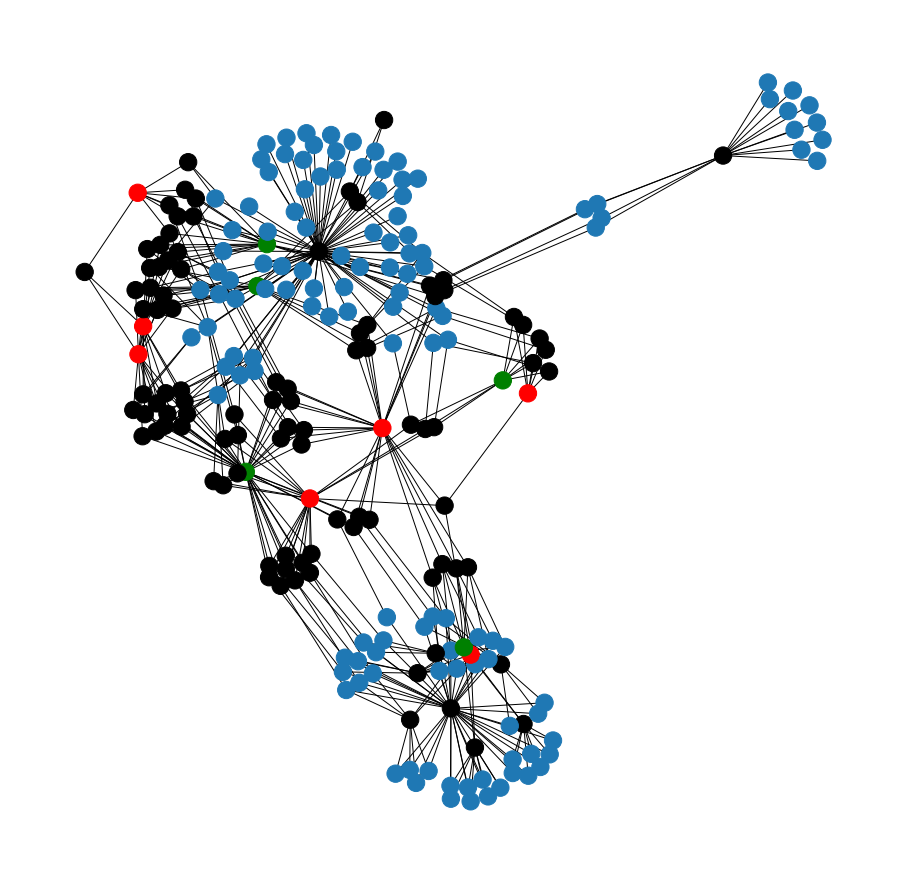

In [30]:
included_relationships.extend([DASHB.produces, DASHB.memberOf])
graph_ = create_subgraph(included_relationships)
visualize_graph(graph_, colored=True)

In [31]:
recommender = recommender_factory.get(RecommenderType.PPR)(graph_)
recommender.set_personalization(0.7, 0.3)

ppr = recommender.run(uid, cid)

In [32]:
recommendations = recommender.predict(uid, cid)

for r in recommendations:
    print(r)

{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/time-series-line-chart-with-time-range-selector'), 'score': 0.027592667859441634}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/modern-gauge'), 'score': 0.0186488489928188}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/traditional-gauge'), 'score': 0.007683197701757788}
{'contextId': ['https://webthing.proeftuin.dynamicdashboard.ilabt.imec.be/things/BBB1/properties/rpm%3A%3Anumber'], 'itemId': rdflib.term.URIRef('http://localhost/web-thing-gateway/things/visualizations/colored-m